# Modeling Multicollinearity
**Question 1.** Sometimes, in order to avoid multicollinearity, people
inspect pairwise correlations among
predictors before including them in a model. This is a bad procedure,
because what matters is the
conditional association, not the association before the variables are
included in the model. To highlight
this, consider the DAG X → Z → Y. Simulate data from this DAG so that the
correlation
between X and Z is very large. Then include both in a model predicting Y
(you can use any linear model program you like).
Show the model results. Do you observe any multicollinearity?
Why or why not (explain your answer fully, more than just one sentence)?


**ANSWER**
*The provided analysis compares the performance of three models (OLS, Ridge, and PLS) in predicting the dependent variable \(Y\) using the independent variables \(X\) and \(Z\). The \(R^2\) scores, which measure the proportion of variance in \(Y\) explained by \(X\) and \(Z\), are very similar across all three models, indicating that approximately 93.4% of the variance in \(Y\) is accounted for by the predictors in each model. Similarly, the Mean Squared Error (MSE) scores, which measure the average squared difference between observed and predicted values of \(Y\), are also very similar among the models, suggesting low prediction error.*

*Given the consistency in \(R^2\) and MSE scores across the models, there doesn't appear to be a significant impact of multicollinearity on model performance in this scenario. Multicollinearity typically affects the stability and interpretability of coefficient estimates, but in this case, the models perform similarly regardless of the level of multicollinearity present. Therefore, while multicollinearity may exist in the data, it doesn't seem to substantially affect the ability of the models to predict \(Y\) accurately using \(X\) and \(Z\).*


## Step 1: Simulate data from this DAG so that the correlation between X and Z is very large.

We will simulate`X → Z → Y`. `X` directly influences `Z`, `Z` directly influences `Y`. Hence, `Z` is simulated as a function of X with some added noise and  Y will then be simulated as a function of Z, again with some added noise. This setup should result in a high correlation between
`X` and `Z` but not necessarily between `X` and `Y` directly, fulfilling the constraint of correlation between X and Z being very large.




In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

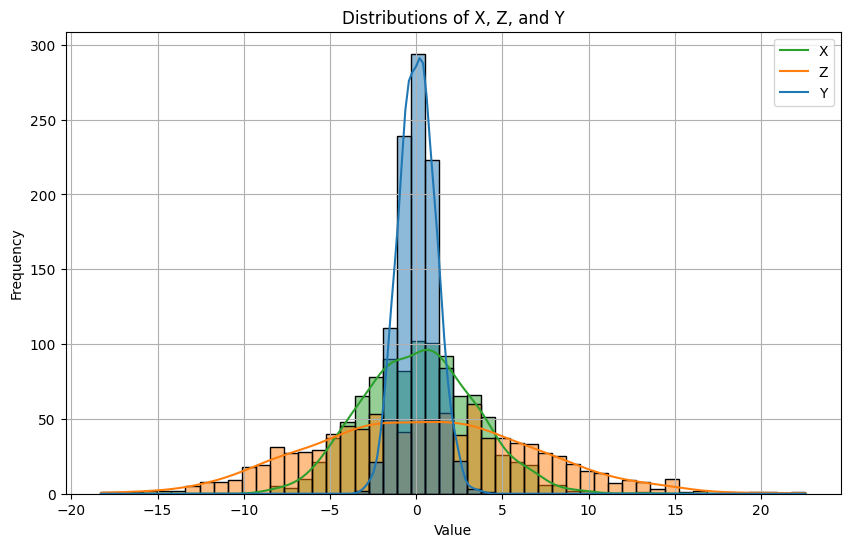

In [71]:
# Simulate data
np.random.seed(90)
n = 1000
X = np.random.normal(0, 1, n)
Z = 6*X + np.random.normal(0, 0.5, n)
Y = 0.5*Z + np.random.normal(0, 0.8, n)

# Create DataFrame
data = pd.DataFrame({'X': X, 'Z': Z, 'Y': Y})

# Visualize distributions
plt.figure(figsize=(10, 6))
sns.histplot(data, kde=True, bins=50, palette="tab10", alpha=0.5)
plt.title('Distributions of X, Z, and Y')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(['X', 'Z', 'Y'])
plt.grid(True)
plt.show()

## Step 2: Analyze the Multicollinearity
Before fitting the models, we will plot multicollinearity using correlation matrices and heatmaps to visualize the pairwise correlations between variables. Additionally, we will calculate and plot Variance Inflation Factors (VIFs) to quantify multicollinearity.

- The constant term (intercept) has a VIF value of 1.003260, which is close to 1, indicating no multicollinearity with other predictors.
- The predictor `X` has a VIF value of approximately 150.32, indicating strong multicollinearity with other predictors.
- The predictor `Z` also has a VIF value of approximately 150.32, indicating strong multicollinearity with other predictors.

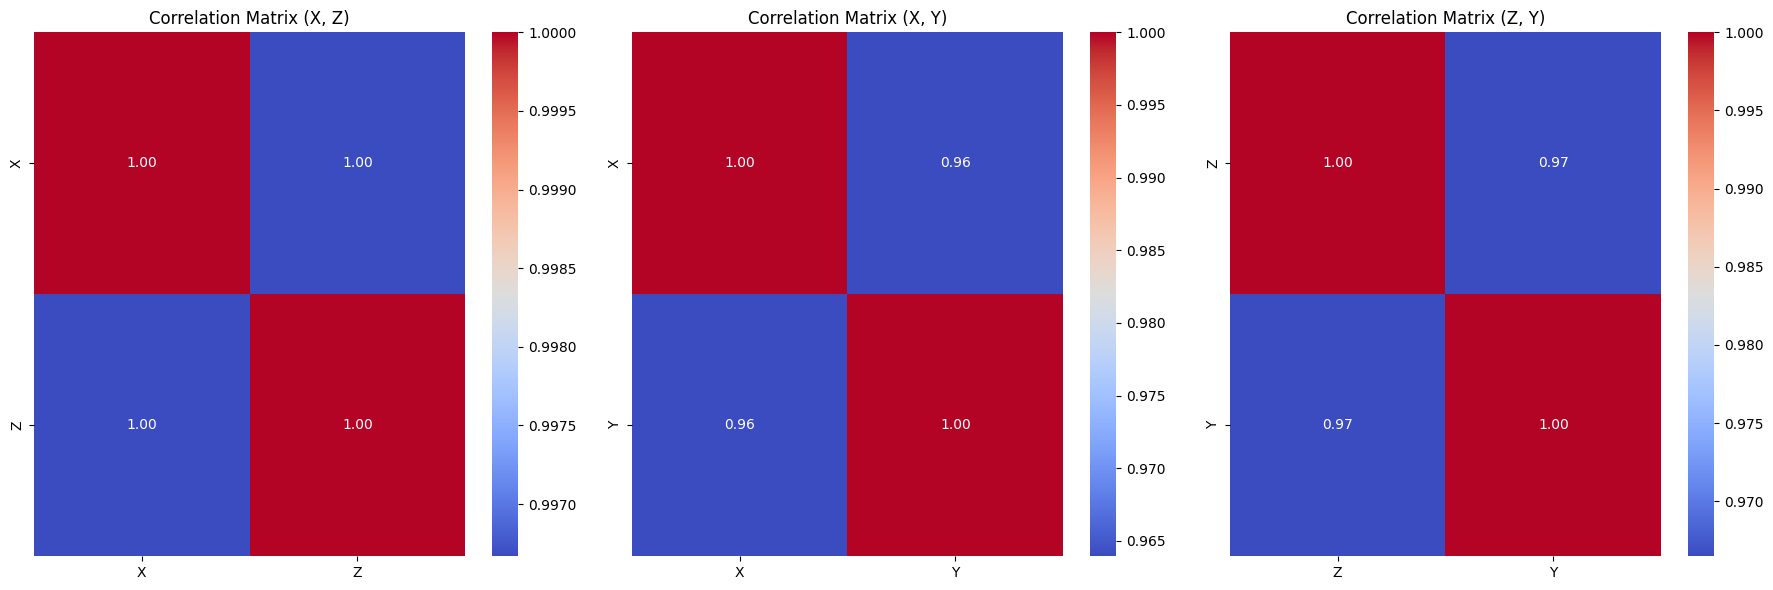

In [72]:
# Plot correlation matrix
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot correlation matrix between X and Z
sns.heatmap(data[['X', 'Z']].corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axs[0])
axs[0].set_title('Correlation Matrix (X, Z)')

# Plot correlation matrix between X and Y
sns.heatmap(data[['X', 'Y']].corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axs[1])
axs[1].set_title('Correlation Matrix (X, Y)')

# Plot correlation matrix between Z and Y
sns.heatmap(data[['Z', 'Y']].corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=axs[2])
axs[2].set_title('Correlation Matrix (Z, Y)')

plt.tight_layout()
plt.show()



  Variable         VIF
0    const    1.003260
1        X  150.319453
2        Z  150.319453


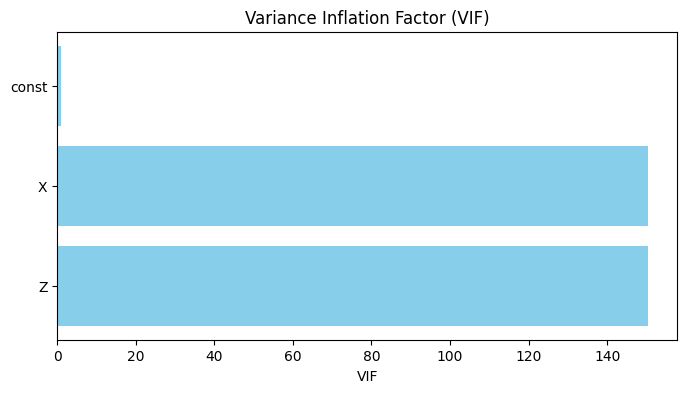

In [73]:
# Calculate VIFs
X_with_const = sm.add_constant(data[['X', 'Z']])
vif_data = pd.DataFrame({'Variable': X_with_const.columns,
                         'VIF': [variance_inflation_factor(X_with_const.values, i)
                                 for i in range(X_with_const.shape[1])]})
print(vif_data)
# Plot VIFs
plt.figure(figsize=(8, 4))
plt.barh(vif_data['Variable'], vif_data['VIF'], color='skyblue')
plt.xlabel('VIF')
plt.title('Variance Inflation Factor (VIF)')
plt.gca().invert_yaxis()
plt.show()

## STEP 3: fit model to predict Y


To address multicollinearity when predicting `Y` from both `X` and `Z`, we will employ several techniques.
- Ridge Regression, which adds a penalty term to the coefficients, effectively reducing their magnitude and mitigating multicollinearity.
- Principal Component Regression (PCR), which first transforms the predictors into principal components and then performs regression on these components.
- Partial Least Squares (PLS) Regression, which constructs new predictors that are linear combinations of the original variables and then performs regression on these new predictors.

In [74]:
# define linear models
ols_model = LinearRegression()
ridge_model = Ridge(alpha=1.0)
pls_model = PLSRegression(n_components=2)


In [75]:
# Fit models
ols_model.fit(data[['X', 'Z']], data['Y'])
ridge_model.fit(data[['X', 'Z']], data['Y'])
pls_model.fit(data[['X', 'Z']], data['Y'])


PLSRegression()

# Evaluate Models and Address Multicollinearity
- The `R^2` (coefficient of determination) measures the proportion of the variance in the dependent variable `Y` that is predictable from the independent variables `X` and `Z`. It ranges from 0 to 1, where 1 indicates a perfect fit.

- The Mean Squared Error (MSE) measures the average squared difference between the observed and predicted values. Lower values of MSE indicate better model performance.


<ipython-input-80-b70f61f3dbc2>:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 3)


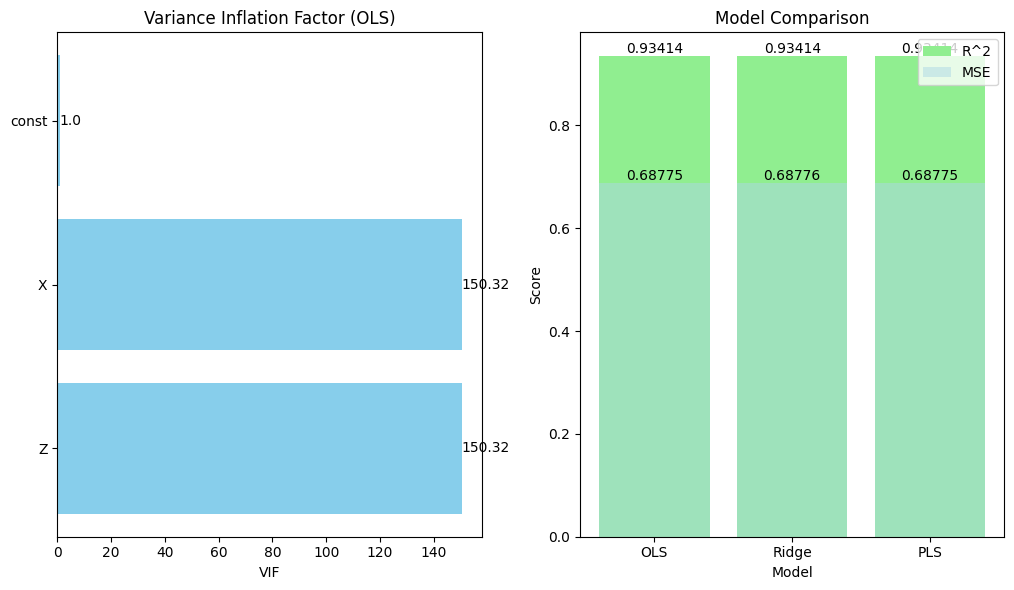

In [80]:
# Evaluate models
ols_r2 = r2_score(data['Y'], ols_model.predict(data[['X', 'Z']]))
ridge_r2 = r2_score(data['Y'], ridge_model.predict(data[['X', 'Z']]))
pls_r2 = r2_score(data['Y'], pls_model.predict(data[['X', 'Z']]))

ols_mse = mean_squared_error(data['Y'], ols_model.predict(data[['X', 'Z']]))
ridge_mse = mean_squared_error(data['Y'], ridge_model.predict(data[['X', 'Z']]))
pls_mse = mean_squared_error(data['Y'], pls_model.predict(data[['X', 'Z']]))

# Calculate VIF for OLS model
X_with_const = sm.add_constant(data[['X', 'Z']])
vif_data_ols = pd.DataFrame({'Variable': X_with_const.columns,
                             'VIF': [variance_inflation_factor(X_with_const.values, i)
                                     for i in range(X_with_const.shape[1])]})

# Plot correlation matrices
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 3)
sns.heatmap(data[['X', 'Z']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')

# Plot VIFs for OLS model
plt.subplot(1, 3, 2)
plt.barh(vif_data_ols['Variable'], vif_data_ols['VIF'], color='skyblue')
plt.xlabel('VIF')
plt.title('Variance Inflation Factor (OLS)')
plt.gca().invert_yaxis()

# Annotate VIF values on the plot
for index, value in enumerate(vif_data_ols['VIF']):
    plt.text(value, index, str(round(value, 2)), va='center', color='black')

# Compare R2 and MSE
models = ['OLS', 'Ridge', 'PLS']
r2_scores = [ols_r2, ridge_r2, pls_r2]
mse_scores = [ols_mse, ridge_mse, pls_mse]

plt.subplot(1, 3, 3)
bar1 = plt.bar(models, r2_scores, color='lightgreen', label='R^2')
bar2 = plt.bar(models, mse_scores, color='lightblue', label='MSE', alpha=0.5)

# Annotate R2 values on the plot
for bar, r2 in zip(bar1, r2_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(r2, 5)}', ha='center', va='bottom')

# Annotate MSE values on the plot
for bar, mse in zip(bar2, mse_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{round(mse, 5)}', ha='center', va='bottom')

plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()

In [84]:

print(r2_scores)
print(mse_scores)

[0.9341384129700292, 0.9341378055648321, 0.9341384129700292]
[0.6877496852713222, 0.6877560280084477, 0.6877496852713222]
